In [ ]:
import numpy as np
from constants import *
import rasterio
from data_preparation import normalize, vis


In [ ]:
city_name = "bologna"

with rasterio.open(SENTINEL_DATASET_DIR / city_name / "R.tiff") as f:
    r_data = np.transpose(f.read(), (1,2,0)).squeeze()
    r_data = normalize(r_data)
with rasterio.open(SENTINEL_DATASET_DIR /  city_name / "G.tiff") as f:
    g_data = np.transpose(f.read(), (1,2,0)).squeeze()    
    g_data = normalize(g_data)
with rasterio.open(SENTINEL_DATASET_DIR /  city_name / "B.tiff") as f:
    b_data = np.transpose(f.read(), (1,2,0)).squeeze()
    b_data = normalize(b_data)
with rasterio.open(SENTINEL_DATASET_DIR /  city_name / "IR.tiff") as f:
    ir_data = np.transpose(f.read(), (1,2,0)).squeeze()
    ir_data = normalize(ir_data)

with rasterio.open(BUILDING_DATASET_DIR / city_name / "footprint.tiff") as f:
    building_data = np.transpose(f.read(), (1,2,0)).squeeze()

In [ ]:
import torch


all_bands = np.stack([
    r_data, 
    g_data, 
    b_data, 
    ir_data
    ], axis=-1)

preprocess_tensor = torch.Tensor(np.stack([
    r_data, 
    g_data, 
    b_data, 
    ir_data, 
    building_data
    ], axis=-1))

In [ ]:
vis(all_bands[:,:,:3], False)

In [ ]:
from matplotlib import pyplot as plt    

plt.figure(figsize=(10,10))
vis(building_data, False)

In [119]:
from typing import Tuple
import torchvision.transforms as T
from torchvision.transforms import functional as TF
from torch.utils.data import TensorDataset
import torch 
import random

patch_size = 32

augmentations = {
    "rotation": T.RandomRotation(30),
    "reflection": T.RandomHorizontalFlip(1),
    "zoom": T.RandomResizedCrop(size=patch_size, scale=(0.6, 1.0)),
    #"modulated_noise": lambda img: img + torch.randn_like(img) * 0.1,
    "affine": T.RandomAffine((50, 60))
}

compound_augmentations = {
    "rotate_reflect": T.Compose([augmentations["rotation"], augmentations["reflection"]]),
    # "rotate_zoom": T.Compose([augmentations["rotation"], augmentations["zoom"]]),
    # "reflect_zoom": T.Compose([augmentations["reflection"], augmentations["zoom"]]),
    # "rotate_reflect_affine": T.Compose([augmentations["rotation"], augmentations["reflection"], augmentations["affine"]]),
    # "all": T.Compose([augmentations["rotation"], augmentations["reflection"], augmentations["zoom"], augmentations["affine"]])
}

def apply_transform(data: Tuple[torch.Tensor, torch.Tensor], transform) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = data    
    print(x.shape, y.shape)
    combined = torch.cat([x, y.unsqueeze(0)], dim=0)
    # x = TF.to_pil_image(x)
    combined = transform(combined)
    
    return combined[:4], combined[4].unsqueeze(0)
    
    
def augment_dataset(dataset: TensorDataset) -> TensorDataset:
    input_tensors, output_tensors = dataset.tensors[0], dataset.tensors[1]

    augmented_datasets = []
    for name, transform in compound_augmentations.items():
        augmented_datasets.append([(apply_transform(data, transform)) for data in dataset])
    return augmented_datasets
    # input_tensors_with_augmented = torch.cat([input_tensors] + [augmented_ds for augmented_ds in augmented_datasets], dim=0)
    


In [109]:
import torch
dataset = torch.load(TRAINING_DATASET_DIR / "64_train.pt")
augmented = augment_dataset(dataset)

In [114]:
augmented[0][0][0].shape

torch.Size([1, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


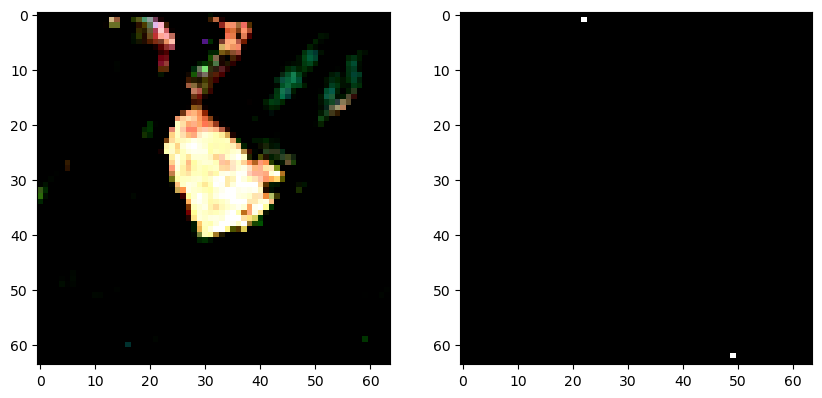

In [115]:
plt.subplots(1,2, figsize=(10,10))
plt.subplot(1,2,1)
vis(augmented[0][0][0][:3,:,:].permute(1,2,0), False)
plt.subplot(1,2,2)
vis(augmented[0][0][1].squeeze().numpy(), False)

torch.Size([64, 64, 4]) torch.Size([64, 64])
torch.Size([4, 64, 64]) torch.Size([64, 64])


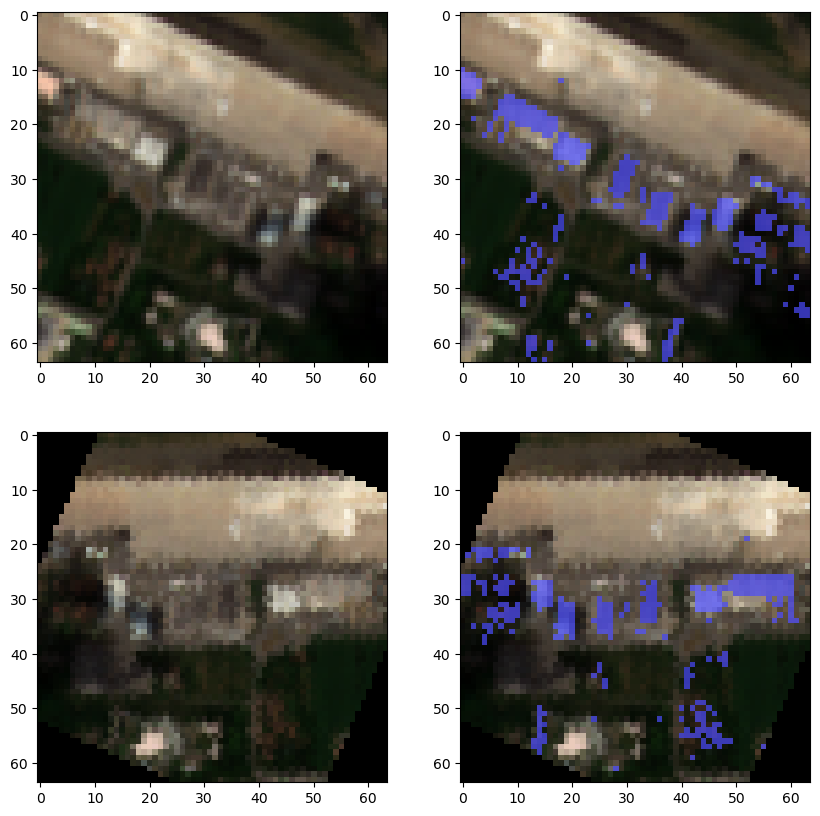

In [127]:
import matplotlib
from data_preparation import create_patches
patch_size = 64
patches = create_patches(preprocess_tensor, patch_size)

blue_cmap = matplotlib.colors.ListedColormap([(0,0,0,0), (0.3,0.3,1,0.7)])
fig, ax = plt.subplots(2,2, figsize=(10,10))
    
patch_id = 110
patch = patches[patch_id]
patch_rgbir = patch[:,:,:4]
patch_building = patch[:,:,4]

ax[0][0].imshow(patches[patch_id,:,:,:3])
ax[0][1].imshow(patches[patch_id,:,:,:3])
ax[0][1].imshow(patches[patch_id,:,:,4], cmap=blue_cmap)

print(patch_rgbir.shape, patch_building.shape)
pretransform_rgb, pretransform_building = patch_rgbir.permute(2,0,1), patch_building
# print(pretransform_rgb.shape, pretransform_building.shape)
tranformed = apply_transform((pretransform_rgb, pretransform_building), compound_augmentations["rotate_reflect"])
augmented_rgbir, augmented_building = tranformed[0].permute(1,2,0), tranformed[1].squeeze(0)

ax[1][0].imshow(augmented_rgbir[:,:,:3])
ax[1][1].imshow(augmented_rgbir[:,:,:3])
ax[1][1].imshow(augmented_building, cmap=blue_cmap)
